In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az
from scipy.stats import entropy

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits
from matplotlib import cm


In [109]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True) 



RuntimeError: Physical devices cannot be modified after being initialized

In [55]:
os.chdir('/home/walml/repos/agnfinder')

In [56]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
# save_dir = 'results/emulated_sampling/30k_burnin'
# save_dir = 'results/emulated_sampling/latest_100000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_100000_64_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_50000_16_optimised'

# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_no_metric'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_metric_by_chain'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_sigmoid'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_mvn_by_obs'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_l10'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_128000_32_optimised_l10'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_40000_16_optimised'  # low z
save_dir = 'results/emulated_sampling/latest_emcee_5000_20000_1_optimised'  # low z
# save_dir = 'results/vanilla_emcee_local'  # high z? or low z x 4?

# save_dir = 'results/vanilla_emcee'

assert os.path.isdir(save_dir)
all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')

# all_galaxy_locs = ['results/emulated_sampling/long_emcee/100k_samples_256_walkers_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/30k_burnin_70k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/1k_burnin_50k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/5k_burnin_100k_samples_256_walkers_ball_1x.h5']

# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_3000_100000_64_optimised_x1.h5'] 
# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_5000_300000_32_optimised_x1.h5'] 




assert all_galaxy_locs
print(len(all_galaxy_locs))

extra_thinning = 1

all_galaxy_locs = sorted(all_galaxy_locs)

2


In [57]:
# open one galaxy for params
with h5py.File(all_galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

marginal_bins = 50
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)
                
galaxies = []
true_observations = len(all_galaxy_locs)
# for n, galaxy_loc in enumerate(galaxy_locs[0:]):  # thinned
for n, galaxy_loc in enumerate(all_galaxy_locs):  # thinned
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
#             if f['is_accepted'][...].mean() < 0.6:
#                 print(f['is_accepted'])
#             else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::extra_thinning]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
                    'fixed_params': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...],
                }
                
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [58]:
# galaxy = galaxies[8]
galaxy = galaxies[-1]

In [59]:
galaxy['fixed_params']

array([0.13672559], dtype=float32)

In [60]:
galaxy['uncertainty']

array([9.3800107e-11, 2.3597785e-10, 3.7740708e-10, 6.0057143e-10,
       2.1946109e-09, 3.5686385e-09, 3.0315255e-09, 1.8521605e-09],
      dtype=float32)

In [61]:
galaxy['true_params']

array([8.7522113e-01, 2.0508261e-01, 1.0668993e-01, 2.0500811e-02,
       3.0998796e-01, 7.5078160e-01, 2.0414199e-01, 4.1140321e-01,
       6.1649651e+01], dtype=float32)

In [62]:
galaxy['true_observations']

array([6.2533401e-10, 3.4823240e-09, 1.5683748e-08, 3.2694441e-08,
       4.6075218e-08, 1.0264747e-07, 7.6561896e-08, 5.5413810e-08],
      dtype=float32)

In [63]:
galaxy['samples'].shape

(20000, 256, 9)

In [64]:
z = np.array([g['fixed_params'].squeeze() for g in galaxies])
z.min(), z.max()

(0.11400784, 0.13672559)

In [65]:
print(z)

[0.11400784 0.13672559]


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.11400784, 0.11627962, 0.11855139, 0.12082316, 0.12309494,
        0.12536672, 0.12763849, 0.12991026, 0.13218203, 0.13445382,
        0.13672559], dtype=float32),
 <a list of 10 Patch objects>)

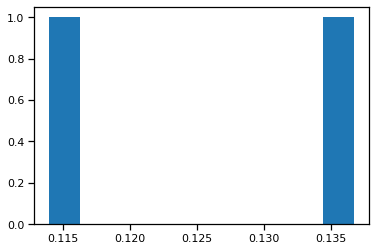

In [66]:
plt.hist(z)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.02850196, 0.0290699 , 0.02963785, 0.03020579, 0.03077373,
        0.03134168, 0.03190962, 0.03247757, 0.03304551, 0.03361345,
        0.0341814 ], dtype=float32),
 <a list of 10 Patch objects>)

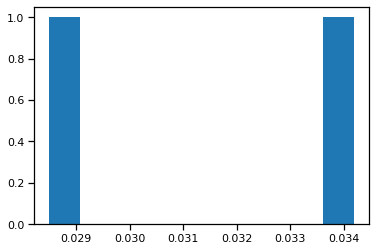

In [67]:
plt.hist(z/4.)

In [68]:
mass = np.array([g['true_params'][0] for g in galaxies])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.87522113, 0.8871853 , 0.8991494 , 0.91111356, 0.9230777 ,
        0.9350418 , 0.9470059 , 0.95897007, 0.9709342 , 0.98289835,
        0.9948625 ], dtype=float32),
 <a list of 10 Patch objects>)

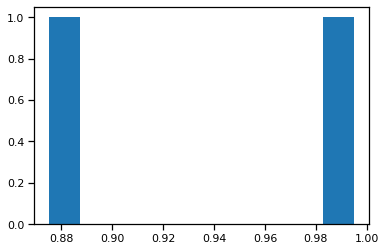

In [69]:
plt.hist(mass)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.87522113, 0.8871853 , 0.8991494 , 0.91111356, 0.9230777 ,
        0.9350418 , 0.9470059 , 0.95897007, 0.9709342 , 0.98289835,
        0.9948625 ], dtype=float32),
 <a list of 10 Patch objects>)

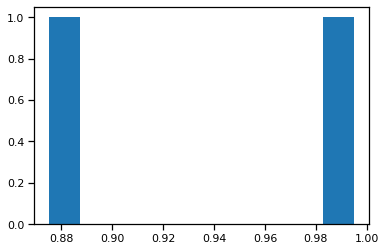

In [70]:
plt.hist(mass)

In [71]:
# galaxy_locs = [x for x in all_galaxy_locs if 'galaxy__' in x]

In [72]:
# galaxy_locs

In [73]:
# n_chains = 256
# # n_chains = 64
# # n_chains = 1
# by_chain = np.reshape(galaxy['samples'], (-1, n_chains, 8))

In [74]:
# by_chain = np.stack([np.squeeze(g['samples']) for g in galaxies], axis=1)
# by_chain.shape

In [75]:
# by_chain.shape
by_chain_raw = galaxy['samples']
param_dim = len(galaxy['true_params'])

In [76]:
# from agnfinder.tf_sampling.hmc import get_covariances

In [77]:
# cov, inv = get_covariances(by_chain)

In [78]:
# cov_np = np.cov(by_chain[:, 0].transpose())
# diag_mask = np.eye(8, 8).astype(bool)
# cov_masked = cov_np.copy()
# cov_masked[diag_mask] = np.nan

In [79]:
# np.matmul(x-x.mean(), (y-y.mean()).transpose())/len(x)

In [80]:
# x = by_chain[:, 0, 0]
# y = by_chain[:, 0, 4]
# plt.scatter(x, y)

In [81]:
# def manual_covariance(x, y):
#     x_mu = x.mean()
#     y_mu = y.mean()
#     return np.mean((x - x_mu)*(y-y_mu))

In [82]:
# manual_covariance(x, y) / (x.std() * y.std())

In [83]:
# d = np.stack([x, y])
# print(d.shape)
# np.cov(d)

In [84]:
# sns.heatmap(cov_np)

In [85]:
# sns.heatmap(cov_masked)

In [86]:
# np.sqrt(cov[0])

In [87]:
# sns.heatmap(cov[0])

In [88]:
by_chain_raw[0:10, 1, :]

array([[7.04362772e-01, 2.83391607e-01, 1.30954769e-01, 6.07977973e-02,
        2.34361377e-01, 9.15358187e-01, 4.19596001e-01, 8.01913842e-01,
        6.16095251e+01],
       [7.04362772e-01, 2.83391607e-01, 1.30954769e-01, 6.07977973e-02,
        2.34361377e-01, 9.15358187e-01, 4.19596001e-01, 8.01913842e-01,
        6.16095251e+01],
       [7.04362772e-01, 2.83391607e-01, 1.30954769e-01, 6.07977973e-02,
        2.34361377e-01, 9.15358187e-01, 4.19596001e-01, 8.01913842e-01,
        6.16095251e+01],
       [7.04042772e-01, 2.83641607e-01, 1.30904769e-01, 6.06777973e-02,
        2.34411377e-01, 9.16048187e-01, 4.19606001e-01, 8.02693842e-01,
        6.16094451e+01],
       [7.04042772e-01, 2.83641607e-01, 1.30904769e-01, 6.06777973e-02,
        2.34411377e-01, 9.16048187e-01, 4.19606001e-01, 8.02693842e-01,
        6.16094451e+01],
       [6.79432772e-01, 3.07921607e-01, 1.28584769e-01, 5.30177973e-02,
        2.56191377e-01, 9.83638187e-01, 4.82486001e-01, 8.30383842e-01,
        6.1

In [89]:
by_chain_raw[4995:5005, 1, :]

array([[9.58522267e-01, 5.82683232e-02, 2.04273199e-01, 1.84970411e-01,
        2.46384953e-01, 3.34661747e-01, 4.66491349e-02, 2.58049327e-01,
        6.16638180e+01],
       [9.58522267e-01, 5.82683232e-02, 2.04273199e-01, 1.84970411e-01,
        2.46384953e-01, 3.34661747e-01, 4.66491349e-02, 2.58049327e-01,
        6.16638180e+01],
       [9.58522267e-01, 5.82683232e-02, 2.04273199e-01, 1.84970411e-01,
        2.46384953e-01, 3.34661747e-01, 4.66491349e-02, 2.58049327e-01,
        6.16638180e+01],
       [9.58522267e-01, 5.82683232e-02, 2.04273199e-01, 1.84970411e-01,
        2.46384953e-01, 3.34661747e-01, 4.66491349e-02, 2.58049327e-01,
        6.16638180e+01],
       [9.58522267e-01, 5.82683232e-02, 2.04273199e-01, 1.84970411e-01,
        2.46384953e-01, 3.34661747e-01, 4.66491349e-02, 2.58049327e-01,
        6.16638180e+01],
       [9.58519024e-01, 5.82681141e-02, 2.04277729e-01, 1.84971589e-01,
        2.46385379e-01, 3.34657845e-01, 4.66458796e-02, 2.58049077e-01,
        6.1

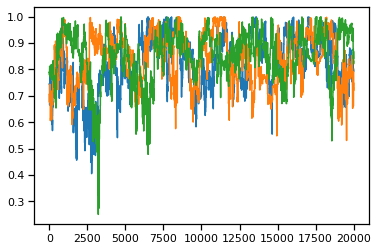

In [90]:
plt.plot(by_chain_raw[:, :3, 0])

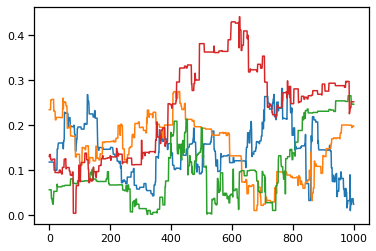

In [91]:
plt.plot(by_chain_raw[:1000, :4, 4])

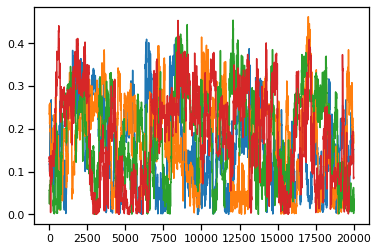

In [92]:
plt.plot(by_chain_raw[:, :4, 4])

In [93]:
by_chain_raw[0, 0]

array([7.45312772e-01, 2.58541607e-01, 1.17124769e-01, 4.72977973e-02,
       1.18081377e-01, 3.60628187e-01, 4.00626001e-01, 1.09303842e-01,
       6.15255851e+01])

In [94]:
by_chain_raw[1, 0]

array([7.45312772e-01, 2.58541607e-01, 1.17124769e-01, 4.72977973e-02,
       1.18081377e-01, 3.60628187e-01, 4.00626001e-01, 1.09303842e-01,
       6.15255851e+01])

In [95]:
def get_kl_vs_other_chains(chains, min_p=1e-5):
    n_chains = chains.shape[1]
    n_params = chains.shape[2]
    kl_divs = np.zeros([n_params, n_chains]) * np.nan
#     for param_n in range(n_params):
    for param_n in [0]:
        for chain_n in range(n_chains):
#             print(param_n, chain_n)
    #     for chain_n in [1]:
            mask = np.ones(n_chains).astype(bool)
            mask[chain_n] = False
            this_chain = chains[:, chain_n]
    #         other_chains = chains[:, mask]
            other_chains = chains
    #         print(this_chain.shape, other_chains.shape)
            bins = np.linspace(0., 1., 10)
            other_probs, _ = np.histogram(other_chains[:, :, param_n], density=True, bins=bins)
            this_probs, _ = np.histogram(this_chain[:, param_n], density=True, bins=bins)
            allowed_probs = (other_probs > min_p) & (this_probs > min_p)
    #         plt.plot(this_probs)~
    #         plt.plot(other_probs)
    #         print(other_probs)
    #         print(this_probs)
            kl_divs[param_n, chain_n] = entropy(other_probs[allowed_probs], this_probs[allowed_probs])  # calculates KL of q (second arg) approximating p (first arg)
    return kl_divs

In [96]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
# print(kl_divs)

KeyboardInterrupt: 

In [ ]:
# fig, axes = plt.subplots(nrows=by_chain.shape[2], figsize=(8, 12))
# for n, ax in enumerate(axes):
#     ax.hist(kl_divs[n])
# fig.tight_layout()

In [ ]:
worst_chain_n = np.argmax(kl_divs)
worst_chain_n

In [ ]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
kl_divs = kl_divs[0]
print(kl_divs)
kl_is_successful = kl_divs < (np.median(kl_divs) + kl_divs.std() * 2)

typical_std = np.median(by_chain_raw.std(axis=0)[:, 0])
chain_stds = by_chain_raw.std(axis=0)[:, 0]
std_is_successful = chain_stds > typical_std * 0.1

print(std_is_successful)
chain_is_successful = kl_is_successful & std_is_successful
print(chain_is_successful)

In [ ]:
plt.hist(kl_divs, bins=10)

In [ ]:
# chain_is_successful = True

In [97]:
by_chain = by_chain_raw

IndexError: too many indices for array

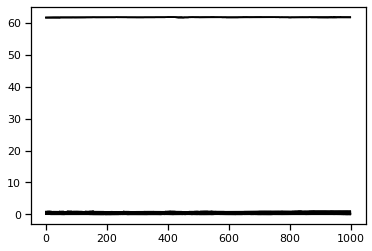

In [98]:
# plt.plot(by_chain_raw[:1000, chain_is_successful, 0].mean(axis=1), 'k--')
plt.plot(by_chain_raw[:1000, chain_is_successful, 0][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 1][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 2][:, 0], color='k')
plt.plot(by_chain_raw[:1000, ~chain_is_successful, 0][:, 0], color='r')

In [ ]:
plt.hist(by_chain_raw[:, chain_is_successful, 0].flatten())

In [ ]:
plt.hist(by_chain_raw[:, ~chain_is_successful, 0].flatten())

In [ ]:
# from sklearn.metrics import adjusted_mutual_info_score

# adjusted_mutual_info_score(by_chain[:, 0, 0], by_chain[:, 4, 0])

In [ ]:
# _ = corner.corner(by_chain[:500].reshape(-1, 8), labels=params)  # early phase only

In [ ]:
# _ = corner.corner(by_chain[-5000:].reshape(-1, 8), labels=params)  # late phase only

In [99]:
true_params = galaxy['true_params']

In [100]:
true_params

array([8.7522113e-01, 2.0508261e-01, 1.0668993e-01, 2.0500811e-02,
       3.0998796e-01, 7.5078160e-01, 2.0414199e-01, 4.1140321e-01,
       6.1649651e+01], dtype=float32)

In [101]:
def plot_corner(samples, true_params, labels):
    fig = corner.corner(samples, labels=labels)

    # Extract the axes
    axes = np.array(fig.axes).reshape((param_dim, param_dim))

    # Loop over the diagonal
    for i in range(param_dim):
        ax = axes[i, i]
        ax.axvline(true_params[i], color="g")

    true_params = galaxy['true_params']
    # Loop over the histograms
    for yi in range(param_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_params[xi], color="g")
            ax.axhline(true_params[yi], color="g")

    fig

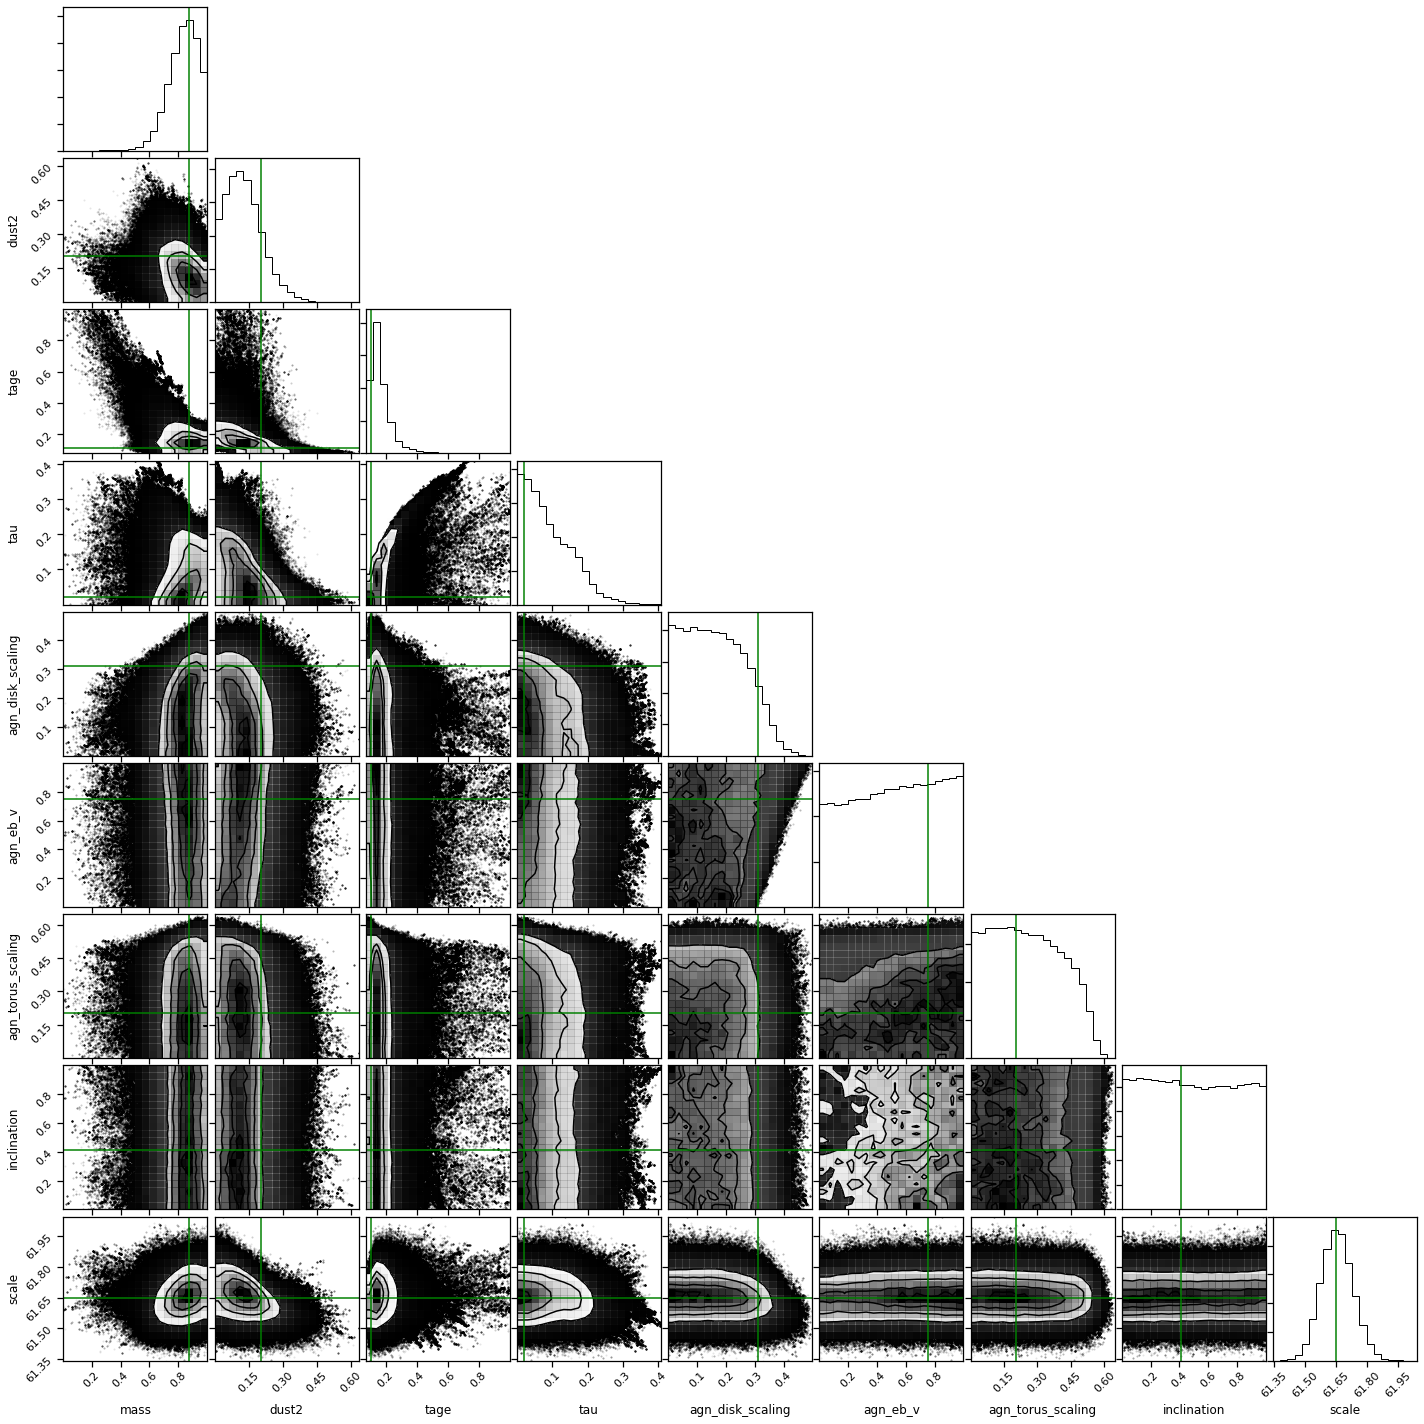

In [102]:
plot_corner(galaxy['samples'].reshape(-1, param_dim), true_params, params)

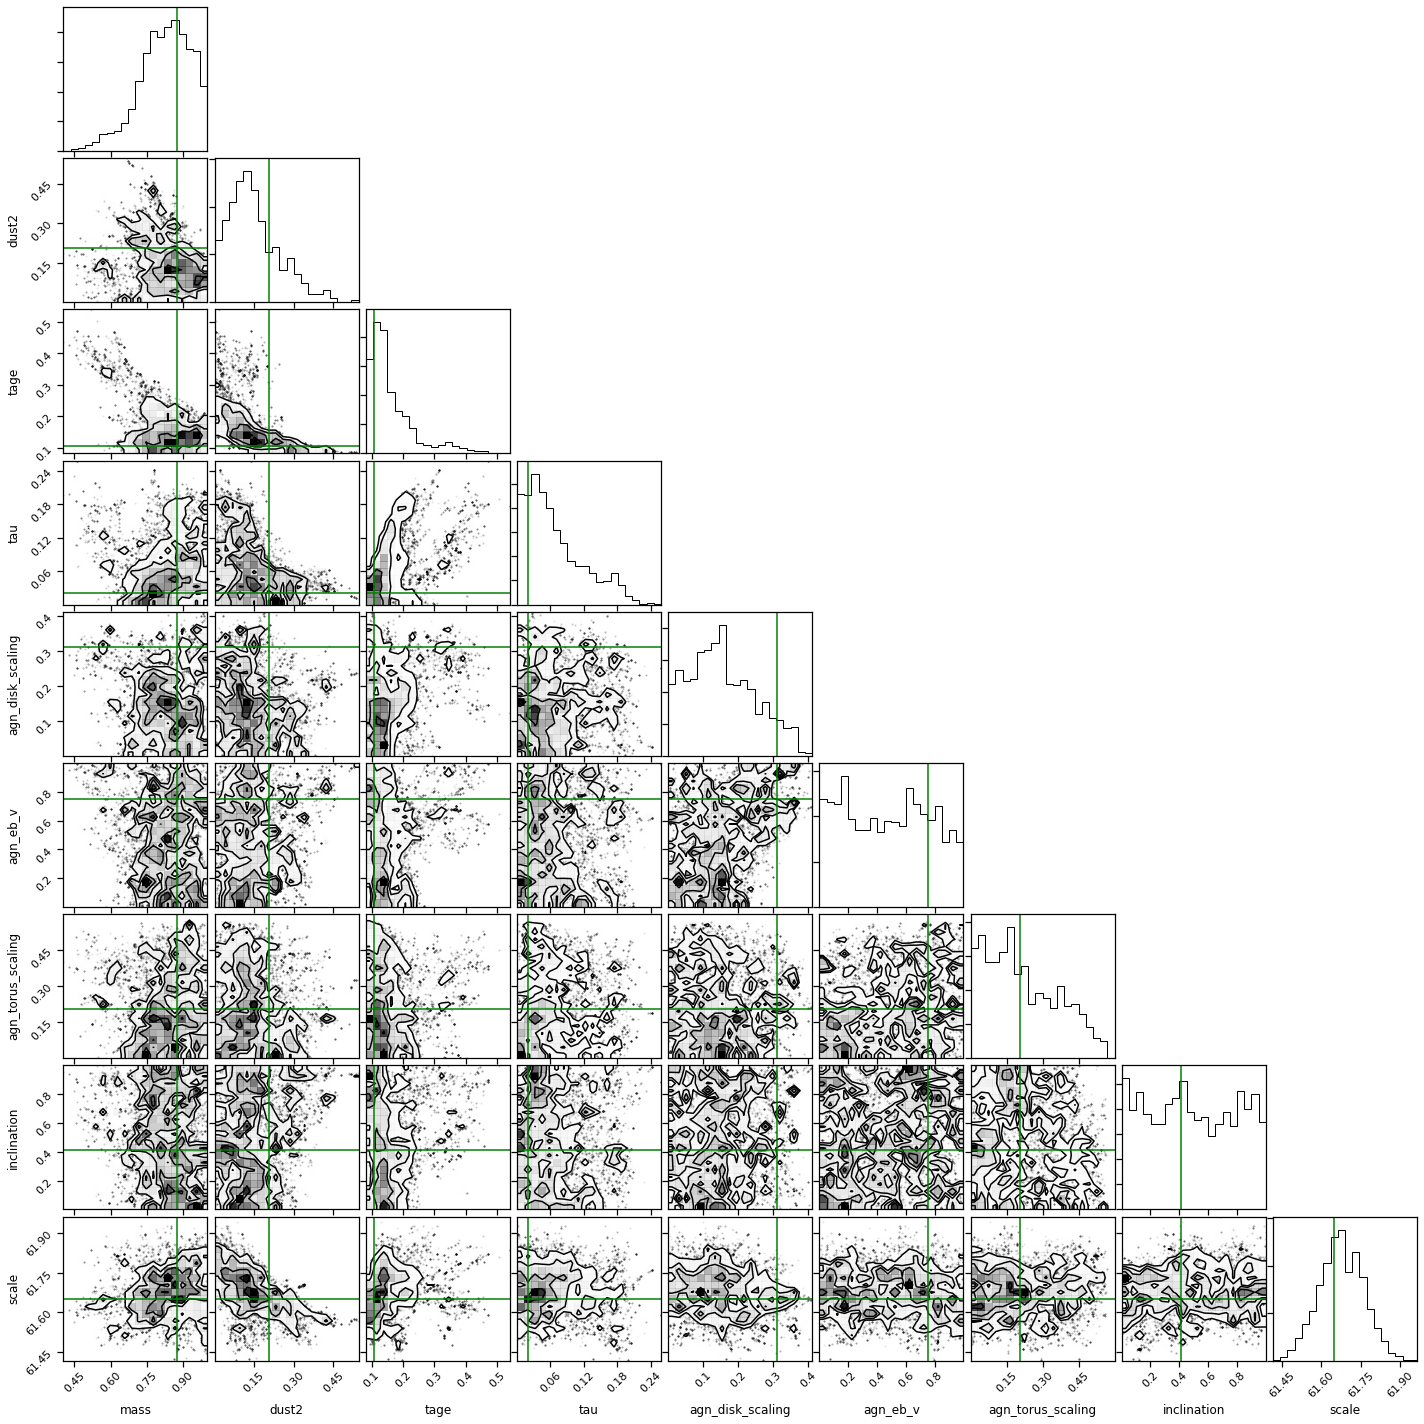

In [103]:
plot_corner(galaxy['samples'][:, 0], true_params, params)

In [ ]:
# plot_corner(by_chain_raw.reshape(-1, param_dim), true_params, params)

In [ ]:
# _ = corner.corner(by_chain.reshape(-1, param_dim), labels=params)

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

In [ ]:
samples = by_chain.reshape(-1, param_dim)
mu = np.mean(samples, axis=0)

cov = np.loadtxt('latest_cov.npy').astype(np.float32)
# cov = tfp.stats.covariance(samples)  # or just np cov?
chol = tf.linalg.cholesky(cov)
approx_dist = tfp.distributions.MultivariateNormalTriL(
    loc=mu, scale_tril=chol, validate_args=True, allow_nan_stats=False
)


bijector = tfp.bijectors.ScaleMatvecTriL(scale_tril=chol)

In [ ]:
bijector

In [ ]:
b = tfp.bijectors.ScaleMatvecTriL(scale_tril=[chol for _ in range(by_chain.shape[1])])


In [ ]:
b.inverse(by_chain).shape

In [ ]:
approximated_samples = approx_dist.sample(10000)
_ = corner.corner(approximated_samples, range=[[0, 1] for _ in range(8)])
# only mass/agn mass are strongly covariant, but the std of many params is very different (as expected, and already dealt with)

In [ ]:
uniform = tf.random.uniform([10000, 8])
_ = corner.corner(bijector.forward(uniform))

In [ ]:
sns.heatmap(cov)

In [ ]:
from agnfinder.tf_sampling.hmc import get_decorrelation_bijector

In [ ]:
observation_ids = [np.random.choice(['a', 'b']) for _ in range(by_chain.shape[1])]

In [ ]:
batch_bijector = get_decorrelation_bijector(by_chain, observation_ids)

In [ ]:
batch_bijector.forward_event_shape(tf.shape(uniform))

In [ ]:
batch_bijector.inverse(np.array([uniform for _ in range(29)]))

In [ ]:
for n in [100, 500, 5000]:
    b = get_decorrelation_bijector(by_chain[:n, 0])  # even w/ 1 chain, 1000 is about enough
    _ = corner.corner(b.inverse(samples))


In [ ]:
for n in [100, 1000, 5000]:
    b = get_decorrelation_bijector(samples[:n])  # merging across chains,  
    _ = corner.corner(b.inverse(samples))


In [ ]:
assert False

In [ ]:
_ = corner.corner(bijector.inverse(approximated_samples))

These have weird ranges, but are actually same scale - about 6

In [ ]:
_ = corner.corner(bijector.inverse(samples))

In [ ]:
# _ = corner.corner(by_chain_not_bad[::10].reshape(-1, 8), labels=params)

## Marginals

### Marginals, cut by n-samples

In [ ]:
def get_marginals(samples, marginal_bins=100, param_dim=9):
    dummy_array = np.zeros(42)  # anything
    _, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)

    marginals = np.zeros((param_dim, marginal_bins))
    for param_n in range(param_dim):
        marginals[param_n], _ = np.histogram(samples[:, :, param_n].flatten(), density=True, bins=param_bins)  # galaxy samples is still dim3, confusingly

    return marginals, param_bins

In [ ]:
params

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

# limits = [
#     [0., 1.],
# #     [.5, .6],
#     [.1, .5],
#     [0., .2],
#     [0., 0.2],
#     [0., 0.7],
#     [0., 1.],
#     [0., 0.6],
#     [0., 1.]
# ]
limits = [[0., 1.] for _ in range(len(params))]
limits[-1] = [None, None]  # scale parameter don't mess with

cuts = np.logspace(3, np.log10(len(by_chain)), num=6).astype(int)
# tau_est = np.array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453]) / 10.

max_chains = 32

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(cuts):
        marginals, bins = get_marginals(by_chain[:cut, :max_chains, :], marginal_bins=100, param_dim=len(params))
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=cut)
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()
    

### Marginals, cut by n-chains

Note that this is only relevant for HMC, as the performance by-chain for emcee is not defined - chains are dependent!

In [ ]:
true_params = galaxy['true_params']
true_params

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(5, by_chain.shape[1], num=5).astype(int)
max_samples = 40000

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain[:max_samples, :cut, :], param_dim=len(params))
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

## Identify bad chains, and remove them.

HMC only, as emcee chains are dependent.
For emcee, starting in a ball should prevent this anyway?

In [ ]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [ ]:
ds = az.convert_to_dataset(np.swapaxes(by_chain, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity
# ds_hmc = az.convert_to_dataset(np.swapaxes(by_chain_not_bad, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [ ]:
ds

In [ ]:
# Trim the most extreme 5% percentiles?
mass_samples = by_chain[:, :, 0].flatten()
low, high = np.percentile(mass_samples, [2, 98])
print(low, high)
mass_samples_trimmed = mass_samples[(mass_samples > low) & (mass_samples < high)]

In [ ]:
_ = plt.hist(mass_samples, bins=50, alpha=0.5, density=True)
_ = plt.hist(mass_samples_trimmed, bins=50, alpha=0.5, density=True)

In [ ]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

In [ ]:
std_devs = np.random.rand(*by_chain.shape[1:])
observation_ids = [np.random.choice(['a', 'b', 'c']) for _ in range(by_chain.shape[1])]
std_devs_df = pd.DataFrame(data=std_devs, index=observation_ids).reset_index()  # columns are params (int range)
std_devs_by_galaxy = std_devs_df.groupby('index').agg('mean')
# for obs_id in self.observation_ids:

In [ ]:
std_devs_by_galaxy

In [ ]:
dict(zip(std_devs_by_galaxy.index, std_devs_by_galaxy.values))

In [ ]:
std_devs_df.head()

In [ ]:
np.argmax(np.median(by_chain[:, :, 0], axis=0))

In [104]:
from agnfinder.tf_sampling import deep_emulator

In [105]:
forward_model = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), 'results/checkpoints/latest', new=False, cube_dir='data/cubes/latest')

RuntimeError: Physical devices cannot be modified after being initialized

In [131]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])

In [110]:
def get_expected_photometry(x):
    scale = x[:, -1]
#     print(scale)
    p = x[:, :-1]
    x_with_fixed_params = tf.concat([fixed_params, p], axis=1)
    norm_photometry = forward_model(x_with_fixed_params)
#     print(norm_photometry)
    return deep_emulator.denormalise_photometry(norm_photometry, scale=scale).numpy()

In [111]:
fixed_params = galaxy['fixed_params'].reshape(1, -1)
fixed_params

array([[0.13672559]], dtype=float32)

In [112]:
free_params = np.random.rand(param_dim).reshape(1, -1)

In [113]:
fixed_params.shape, free_params.shape

((1, 1), (1, 9))

In [114]:
x = np.concatenate([fixed_params, free_params], axis=1)

In [115]:
get_expected_photometry(free_params)

array([[0.8592312 , 0.86227554, 0.8617251 , 0.86268455, 0.86239034,
        0.8618566 , 0.8638148 , 0.8652661 ]], dtype=float32)

In [116]:
by_chain[0, 0, :]

array([7.45312772e-01, 2.58541607e-01, 1.17124769e-01, 4.72977973e-02,
       1.18081377e-01, 3.60628187e-01, 4.00626001e-01, 1.09303842e-01,
       6.15255851e+01])

In [117]:
by_chain.shape

(20000, 256, 9)

In [118]:
by_chain = by_chain.squeeze()

In [119]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))

array([[7.16949833e-10, 3.73698406e-09, 1.57799747e-08, 3.28125758e-08,
        4.67473882e-08, 1.07470335e-07, 7.95120698e-08, 5.51883588e-08]],
      dtype=float32)

In [120]:
galaxy['uncertainty']

array([9.3800107e-11, 2.3597785e-10, 3.7740708e-10, 6.0057143e-10,
       2.1946109e-09, 3.5686385e-09, 3.0315255e-09, 1.8521605e-09],
      dtype=float32)

NameError: name 'expected_p' is not defined

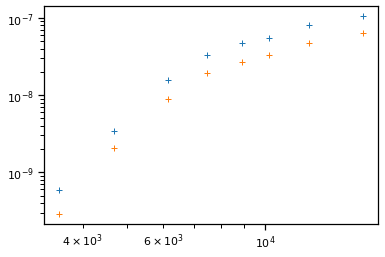

In [132]:
checkpoint_dir = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=False)

from agnfinder.tf_sampling import run_sampler_singlethreaded
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='emulator(true params)')



plt.loglog(wavelengths, fsps(median_params.squeeze()), linestyle='', marker='+', label='FSPS(median params)=observed')
# get_expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
plt.loglog(wavelengths, expected_p/expected_p.sum(), linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_p/fsps_p.sum(), linestyle='', marker='+', label='FSPS(median params)=observed')(emulator)

In [122]:
from agnfinder import simulation_samples

In [123]:
fsps, wavelengths, output_dim = simulation_samples.get_forward_model(emulate_ssp=False, noise=False, filter_selection='euclid')

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  agn_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  agn_eb_v: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)
  agn_torus_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  inclination: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=90.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  logzsol: 0.0 
  sfh: 4 
  imf_type: 2 
  dust_type: 2 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 
  add_igm_absorption: True 
 

In [124]:
true_params

array([8.7522113e-01, 2.0508261e-01, 1.0668993e-01, 2.0500811e-02,
       3.0998796e-01, 7.5078160e-01, 2.0414199e-01, 4.1140321e-01,
       6.1649651e+01], dtype=float32)

In [125]:
from collections import OrderedDict

In [126]:
param_dim

9

In [127]:
fixed_params

array([[0.13672559]], dtype=float32)

In [128]:
by_chain[0, 0, -1]

61.525585071374444

In [129]:
fsps_free_params = np.median(by_chain, axis=[0, 1])[:-1]  # excluding scale
fsps_scale = np.median(by_chain, axis=[0, 1])[-1]

print(fsps_free_params)
fsps_params = np.concatenate([fixed_params, np.expand_dims(fsps_free_params, axis=0)], axis=1)

print(fsps_params)

# norm_median_params = np.median(by_chain, axis=[0, 1])
# fsps_params = 

# norm_median_params = norm_median_params.reshape(1, -1)
median_params = simulation_utils.denormalise_theta(fsps_params, simulation_samples.FREE_PARAMS)
print(median_params)


[0.84197149 0.12160138 0.14939141 0.07423352 0.15780243 0.53408083
 0.24424922 0.48958922]
[[0.13672559 0.84197149 0.12160138 0.14939141 0.07423352 0.15780243
  0.53408083 0.24424922 0.48958922]]
[[5.46902359e-01 2.33284550e+11 2.43202766e-01 2.06245201e+00
  1.52716314e-01 1.95077442e-06 2.67040415e-01 9.93124913e-06
  4.40630298e+01]]


Text(0, 0.5, 'Flux (Maggies)')

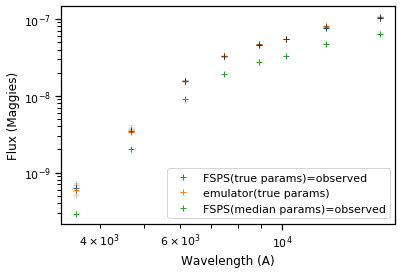

In [133]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='emulator(true params)')



plt.loglog(wavelengths, fsps(median_params.squeeze()), linestyle='', marker='+', label='FSPS(median params)=observed')

for n in range(15):
    plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./16.)
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (Maggies)')

In [ ]:
expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
plt.loglog(wavelengths, expected_p/expected_p.sum(), linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_p/fsps_p.sum(), linestyle='', marker='+', label='FSPS(median params)=observed')

In [ ]:
# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
plt.errorbar(x=wavelengths, y=galaxy['true_observations'], yerr=2*galaxy['uncertainty'], linestyle='', label='FSPS(true params)=observed')

expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
# plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
fsps_norm = deep_emulator.normalise_photometry(np.expand_dims(fsps_p, axis=0))
fsps_flux = np.squeeze(deep_emulator.denormalise_photometry(fsps_norm, scale=fsps_scale))
plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_flux, linestyle='', marker='+', label='FSPS(median sample)')

plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=('emulator(median sample)'))
plt.legend()

# for n in range(15):
#     plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./16.)


plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (Maggies)')



In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
ax.errorbar(x=wavelengths, y=[0 for _ in range(len(fsps_p))], yerr=2*galaxy['uncertainty'], linestyle='', label='Uncertainties in observed', color='k', alpha=0.3)
ax.axhline(0., color='k', alpha=0.05)

expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
# plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
fsps_norm = deep_emulator.normalise_photometry(np.expand_dims(fsps_p, axis=0))
fsps_flux = np.squeeze(deep_emulator.denormalise_photometry(fsps_norm, scale=fsps_scale))

ax.scatter(wavelengths, expected_p - galaxy['true_observations'], marker='+', label='emulator(true params)')
ax.scatter(wavelengths, fsps_flux - galaxy['true_observations'], marker='+', label='FSPS(median sample)')

ax.scatter(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0] - galaxy['true_observations'], marker='+', label=('emulator(median sample)'))
ax.legend()

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux (Maggies)')



In [ ]:
fsps_scale

In [ ]:
deep_emulator.denormalise_photometry(-np.log10(fsps_p), scale=fsps_scale)

In [ ]:
-np.log10(fsps_p)

In [ ]:
# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='observed')
# plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='true params')
# plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=)
for n in range(15):
    plt.loglog(wavelengths, galaxy['true_observations'] - get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./4.)
# plt.legend()

In [ ]:
plt.axhline(0., linestyle='--')
for n in range(15):
    plt.scatter(wavelengths, galaxy['true_observations'] - get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], marker='+', color='k', alpha=1./4.)
    plt.ylim([-1e-8, 1e-8])
    plt.xscale('log')
# plt.legend()

In [ ]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0]

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true', color='k')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 34, :].reshape(1, -1))[0], linestyle='', marker='+', color='r')

In [ ]:
by_chain_not_bad = np.concatenate([by_chain[:, :34], by_chain[:, 35:]], axis=1)
by_chain_not_bad.shape

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, 51, num=5).astype(int)

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain_not_bad[:, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

In [ ]:
from emcee.autocorr import integrated_time

In [ ]:
# emcee is happy with time, walkers, dimensions
tau_est = integrated_time(by_chain, quiet=True)
tau_est

In [ ]:
# array([ 628.51810087,  656.14108053,  858.91637139,  925.08219734,
#        1049.84372125, 3584.59257398, 1421.13224327, 3356.72261827])

# hmc

In [ ]:
# # emcee is happy with time, walkers, dimensions
# tau_est_not_bad = integrated_time(by_chain_not_bad, quiet=True)
# tau_est_not_bad

In [ ]:
sns.barplot(y=params, x=tau_est)  # estimate tau using all chains

In [ ]:
# extinction and inclination are the most uncertain, both almost totally unknown

In [ ]:
sns.barplot(y=params, x=len(by_chain)/tau_est)  # effective samples per chain

In [ ]:
# hmc, no thinning, 1 chain (probably not a good estimate?):

# array([4594.71930395, 4106.71578812, 3291.08818621, 4068.70526458,
#        2642.20579738, 6012.44976159, 5008.85703236, 5370.88693979])

In [ ]:
# 100k samples, 30k burnin, no thinning, 256 walkers, emcee:
    
# array([4747.67220695, 4897.18058522, 5929.65856414, 5970.30192595,
#        4055.12796419, 2566.78810495, 3377.97829428, 2423.96171419])

# (too short for reliable estimate)

In [ ]:
tau_est * 10  # in real samples, prop.compute time

In [ ]:
# 100k samples, 30k burnin, 10x thinning, 256 walkers, emcee:
    
# array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453])



In [ ]:
# 100k samples HMC, 10k burnin, 10x thinning, 64 walkers, hmc:
    
# array([ 6285.1810087 ,  6561.41080526,  8589.1637139 ,  9250.82197341,
#        10498.43721253, 35845.92573981, 14211.32243268, 33567.22618269])

In [ ]:
geweke = az.geweke(np.swapaxes(galaxy['samples'], 0, 1))
geweke.shape
# plt.plot(geweke[:, 1])

In [ ]:
geweke

In [ ]:
plt.plot(geweke[:, 0])

In [ ]:
rhat = az.rhat(ds)
rhat_values = rhat.x.values
print('Not valid for emcee! walkers are correlated')
print('Values greater than one indicate that one or more chains have not yet converged.')
for n, p in enumerate(params):
    print(p, '{:.2f}'.format(rhat_values[n]))

In [ ]:
# may not be valid for walkers?

In [ ]:
_ = az.plot_autocorr(ds, max_lag=4000, combined=True)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds.x[0:1].values, max_lag=5000)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds.x[2:3].values, max_lag=5000)  # in thinned units

In [ ]:
# ds.x[30, 100, 7]  # ds.x format is (chain, sample, param)

In [ ]:
_ = az.plot_mcse(ds)

In [ ]:
ds_hmc

In [ ]:
ess = az.ess(ds_hmc)

In [ ]:
ess.x.values

In [ ]:
sns.barplot(y=params, x=ess.x.values)

In [ ]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

In [ ]:
_ = az.plot_ess(ds, kind="quantile")

In [ ]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")

In [ ]:
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/backends/backend.py#L130
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/autocorr.py#L47